## DESeq processing

This is a Jupyter notebook.

To run all cells in the notebook use `Cell --> Run All`.

To run cells one at a time click into the first code cell and key `Shift-Enter` in each cell in sequence.

More information on Jupyter notebooks can be found
[here](http://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Running%20Code.html).

In [1]:
## Set the plot window sizes within the notebook (in inches)
options(repr.plot.width=6, repr.plot.height=6)

In [2]:
## Set the arguments to easy-to-read names
fn.peps <- './data/CMT_peps.csv'  # PEP lists created in the expression pipeline. This is also Supp Table 1 in the manuscript 

## Filenames that don't change between users
data.dir      <- './data/' # Directory of FREYA-provided data
fn.brca.seq   <- paste0(data.dir,'BRCA_rnaseq_paired_noMets.t.txt')
fn.brca.pam50 <- paste0(data.dir,'BRCA_tumorVSnormal_paired.txt')
fn.geneconvs  <- paste0(data.dir,'Canine_Human_Gene_Conversion.txt') # Human-dog gene conversion
fn.cosmic     <- paste0(data.dir,'roles_in_cancer.csv') # COSMIC genes list, should download most recent version instead of using included one?

## Make sure all of the required files exist - quit if any are missing
for( fn in c(fn.peps, fn.brca.seq, fn.brca.pam50, fn.geneconvs, fn.cosmic) ) {
  if(!file.exists(fn)) { print(paste('ERROR: Unable to locate',fn))}
}

In [3]:
# Create an output directory for artifacts (if it doesn't already exists)
system('mkdir -p ./user_data/output')

# Set the output filenames
pep.roles     <- "./user_data/output/PEP_Roles_in_Cancer_Barplot.pdf"
pep.roles.csv <- './user_data/output/PEP_Roles_in_Cancer_summary.csv'
pep.change    <- './user_data/output/PEP_BRCA_AbsLogFoldChange.pdf'

In [4]:
## Load libraries
print('Loading packages...');flush.console()

source("https://bioconductor.org/biocLite.R")
library(BiocInstaller)
biocLite("impute")

library(samr)
library(ggplot2)
library(plyr)

[1] "Loading packages..."


Bioconductor version 3.6 (BiocInstaller 1.28.0), ?biocLite for help
BioC_mirror: https://bioconductor.org
Using Bioconductor 3.6 (BiocInstaller 1.28.0), R 3.4.2 (2017-09-28).
Installing package(s) ‘impute’
Old packages: 'backports', 'BH', 'bindr', 'bindrcpp', 'blob', 'broom', 'callr',
  'cluster', 'curl', 'DBI', 'dbplyr', 'devtools', 'digest', 'forcats',
  'foreach', 'gdtools', 'git2r', 'glmnet', 'haven', 'hexbin', 'Hmisc', 'hms',
  'htmlTable', 'htmlwidgets', 'httpuv', 'hunspell', 'igraph', 'irlba',
  'iterators', 'knitr', 'littler', 'lubridate', 'mapproj', 'maps', 'MASS',
  'Matrix', 'mgcv', 'microbenchmark', 'mvtnorm', 'nlme', 'openssl', 'pbdZMQ',
  'plogr', 'psych', 'quantreg', 'Rcpp', 'remotes', 'reprex', 'reshape2',
  'rlang', 'rmarkdown', 'RMySQL', 'rpart', 'rprojroot', 'RSQLite', 'selectr',
  'sp', 'stringdist', 'stringi', 'stringr', 'testthat', 'tibble', 'tidyr',
  'tidyselect', 'viridis', 'viridisLite', 'withr', 'XML', 'xml2', 'yaml', 'zoo'
Loading required package: impute
Lo

In [5]:
## Load the PEPs
peps      <- read.table(fn.peps, sep=',', header=TRUE, stringsAsFactors=FALSE)
pep.genes <- c( peps[peps$Adenoma_Expression_Pattern < 0.05,'HumanSymbol'], peps[peps$Tumor_Expression_Pattern < 0.05,'HumanSymbol'], peps[peps$Carcinoma_Expression_Pattern < 0.05,'HumanSymbol'] )

## Create PEP lists using 0.05 qvalue cutoff
pep.lists <- data.frame(Gene=pep.genes, PEP=rep(NA, length(pep.genes)))
pep.lists[ pep.lists$Gene %in% peps[peps$Adenoma_Expression_Pattern < 0.05,'HumanSymbol'], 'PEP']   <- 'Adenoma'
pep.lists[ pep.lists$Gene %in% peps[peps$Carcinoma_Expression_Pattern < 0.05,'HumanSymbol'], 'PEP'] <- 'Carcinoma'
pep.lists[ pep.lists$Gene %in% peps[peps$Tumor_Expression_Pattern < 0.05,'HumanSymbol'], 'PEP']     <- 'Tumor'
peps <- pep.lists

In [6]:
## Load the data
dat <- read.table(fn.brca.seq, sep='\t', header=TRUE, row.names=1, check.names=FALSE)
dat <- as.matrix(dat) + 1
dat <- log(dat, base=2)

In [7]:
## Load the labels and subset to the labeled data
labs <- read.table(fn.brca.pam50, header=FALSE, row.names=1, check.names=FALSE)
ids  <- intersect( rownames(labs), rownames(dat) )
dat  <- dat[ids,]
labs <- labs[ids,]

In [8]:
## Subset to homologous genes
genes.all <- read.table(fn.geneconvs, sep='\t', header=TRUE, stringsAsFactors=FALSE)

In [9]:
## Subset PEP list to those also in human data, for our stats
dat.ovlp <- t(dat[,colnames(dat) %in% genes.all$Hum_Symb])
peps     <- peps[peps$Gene %in% rownames(dat.ovlp),]

In [10]:
## Run SAM
sam.seed <- sample(seq(1,1e5),1) 
res <- SAM(dat.ovlp, labs, resp.type='Two class unpaired', genenames=rownames(dat.ovlp), logged2=TRUE, nperm=100, testStatistic='wilcoxon', fdr.output=5e-6, random.seed=sam.seed)
print(paste('Using seed:', sam.seed)); flush.console()

Warning message in factorial(length(y)):
“value out of range in 'gammafn'”

perm= 1
perm= 2
perm= 3
perm= 4
perm= 5
perm= 6
perm= 7
perm= 8
perm= 9
perm= 10
perm= 11
perm= 12
perm= 13
perm= 14
perm= 15
perm= 16
perm= 17
perm= 18
perm= 19
perm= 20
perm= 21
perm= 22
perm= 23
perm= 24
perm= 25
perm= 26
perm= 27
perm= 28
perm= 29
perm= 30
perm= 31
perm= 32
perm= 33
perm= 34
perm= 35
perm= 36
perm= 37
perm= 38
perm= 39
perm= 40
perm= 41
perm= 42
perm= 43
perm= 44
perm= 45
perm= 46
perm= 47
perm= 48
perm= 49
perm= 50
perm= 51
perm= 52
perm= 53
perm= 54
perm= 55
perm= 56
perm= 57
perm= 58
perm= 59
perm= 60
perm= 61
perm= 62
perm= 63
perm= 64
perm= 65
perm= 66
perm= 67
perm= 68
perm= 69
perm= 70
perm= 71
perm= 72
perm= 73
perm= 74
perm= 75
perm= 76
perm= 77
perm= 78
perm= 79
perm= 80
perm= 81
perm= 82
perm= 83
perm= 84
perm= 85
perm= 86
perm= 87
perm= 88
perm= 89
perm= 90
perm= 91
perm= 92
perm= 93
perm= 94
perm= 95
perm= 96
perm= 97
perm= 98
perm= 99
perm= 100

Computing delta table
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
3

In [11]:
## Get counts for sig up/down genes in each of the PEP lists
sig.genes <- as.data.frame(rbind(res$siggenes.table$genes.up, res$siggenes.table$genes.lo))
colnames(sig.genes)[6]       <- 'FoldChange'
sig.genes$FoldChange         <- as.numeric(as.character(sig.genes$FoldChange))
rownames(sig.genes)          <- sig.genes[,'Gene ID']
sig.genes$PEP                <- rownames(sig.genes) %in% peps$Gene
sig.genes$Log10FoldChange    <- log10(sig.genes$FoldChange)
sig.genes$AbsLog10FoldChange <- abs(sig.genes$Log10FoldChange)

peps$AbsLog10FoldChange <- sig.genes[ peps$Gene , 'AbsLog10FoldChange']

In [12]:
## Add non-PEP rows from sig.genes to peps, that way we can have genes in 2+ peps
ids.nonPEP <- rownames(sig.genes)[!rownames(sig.genes) %in% peps$Gene]
tmp  <- data.frame( AbsLog10FoldChange=sig.genes[ids.nonPEP,'AbsLog10FoldChange'], PEP='nonPEP', row.names=ids.nonPEP )
tmp  <- data.frame( Gene=ids.nonPEP, PEP='nonPEP', AbsLog10FoldChange=sig.genes[ids.nonPEP,'AbsLog10FoldChange'] )
peps <- rbind(peps, tmp)
rm(tmp)

In [13]:
#########################################
## Color Palette for manuscript
#####################################
print('Setting color palettes.'); flush.console()

cols <- c('#9DC7D8','#7FA1BE','#EBDA8C','#01B3CA','#4F6E35','#965354','#7DD1B9','#808040','#C6CBCE','#1D4E88','#C78C6C','#F69256','#D2B29E','#8B868C','#E38691','#B490B2') # All colors in palette
cols.hist <- c('#7DD1B9','#EBDA8C','#965354') # order = healthy, benign, malignant
cols.peps <- c('#7FA1BE','#F69256','#E38691') # order = tumor, adenoma, carcinoma

[1] "Setting color palettes."


Warning message:
“Removed 47 rows containing non-finite values (stat_boxplot).”

Warning message:
“Removed 47 rows containing non-finite values (stat_boxplot).”

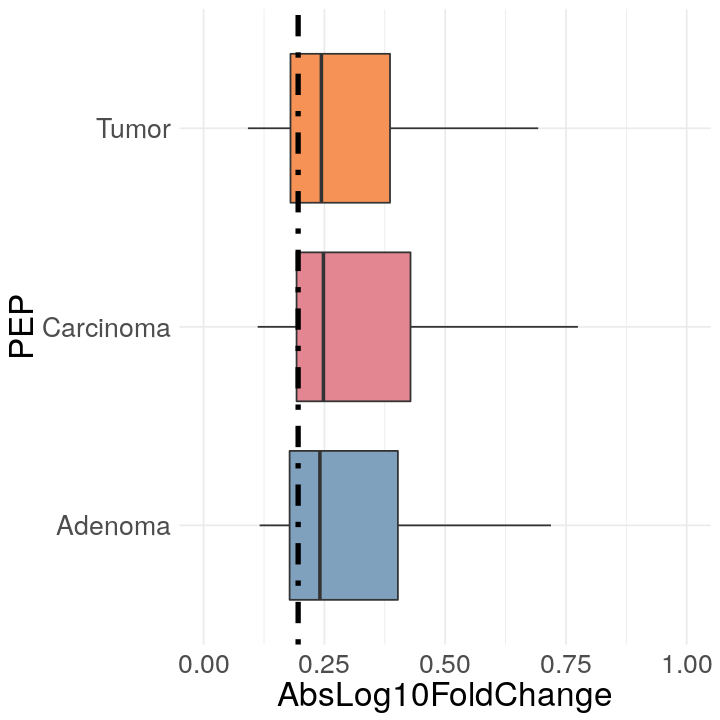

In [14]:
#ggplot(na.omit(peps)) +  # Use if you want to show the nonPEP bar (warning: colors will be incorrect!)
ggplot(na.omit(peps[peps$PEP!='nonPEP',])) + 
  geom_boxplot(aes(PEP, AbsLog10FoldChange, fill=PEP) ,outlier.colour = 'white', outlier.alpha=0) + 
  scale_fill_manual(values=c(cols.peps[c(1,3,2)],'grey')) +
  coord_flip() + 
  ylim(0,1) +
  theme_minimal() +
  theme(axis.title = element_text(size=20), axis.text  = element_text(vjust=0.5, size=16)) +
  geom_hline( aes(yintercept=median(peps[ peps$PEP=='nonPEP', 'AbsLog10FoldChange'])),color='black',linetype='dotdash',lwd=1.5 ) + # Non-PEP genes 
  guides(fill = "none")
ggsave(pep.change,width=8,height=6)

In [15]:
mean(sig.genes$AbsLog10FoldChange)

print('Wilcoxon text absolute log10 fold change of each PEP'); flush.console()
print(wilcox.test(AbsLog10FoldChange ~ PEP=='Adenoma', data = peps)); flush.console()
print(wilcox.test(AbsLog10FoldChange ~ PEP=='Carcinoma', data = peps)); flush.console()
print(wilcox.test(AbsLog10FoldChange ~ PEP=='Tumor', data = peps)); flush.console()


[1] 0.2939227

[1] "Wilcoxon text absolute log10 fold change of each PEP"

	Wilcoxon rank sum test with continuity correction

data:  AbsLog10FoldChange by PEP == "Adenoma"
W = 370620, p-value = 8.981e-08
alternative hypothesis: true location shift is not equal to 0


	Wilcoxon rank sum test with continuity correction

data:  AbsLog10FoldChange by PEP == "Carcinoma"
W = 579240, p-value = 2.596e-13
alternative hypothesis: true location shift is not equal to 0


	Wilcoxon rank sum test with continuity correction

data:  AbsLog10FoldChange by PEP == "Tumor"
W = 1965700, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0



In [16]:
### Print out the list of oncogenes/TSGs, PEP membership, SAM score, and fold change
## This is stored in Supp Table 5 for now.
print('Looking for oncogenes and tumor suppressor genes in the PEPs.'); flush.console()
genes.drivers <- read.table(fn.cosmic, sep=',', header=TRUE, stringsAsFactors=FALSE)
genes.drivers[genes.drivers$Role.in.Cancer=='','Role.in.Cancer'] <- NA
genes.drivers$Role.in.Cancer <- as.factor(genes.drivers$Role.in.Cancer)
colnames(genes.drivers)[1]   <- 'Gene'


[1] "Looking for oncogenes and tumor suppressor genes in the PEPs."


In [17]:
peps    <- peps[peps$Gene %in% rownames(sig.genes),] # Only keep differentially expressed genes
diff.eq <- join( genes.drivers, peps, by='Gene', type='inner')
diff.eq <- diff.eq[complete.cases(diff.eq),]


In [18]:
## Make the table
tbl <- table( diff.eq$Role.in.Cancer, diff.eq$PEP )
tbl <- tbl[,which(colnames(tbl)%in%c('Adenoma','Carcinoma','Tumor'))] # Don't show non-PEP groups
print(tbl); flush.console()


              
               Adenoma Carcinoma Tumor
  oncogene           1         2     3
  oncogene/TSG       0         1     2
  TSG                0         0     6


In [19]:
## Store oncogene & tumor suppressor information to file
print('Storing to file'); flush.console()
write.table(diff.eq[diff.eq$PEP!='nonPEP',], file=pep.roles.csv, col.names=TRUE, row.names=FALSE, quote=FALSE, sep=',')

[1] "Storing to file"


png 
  2

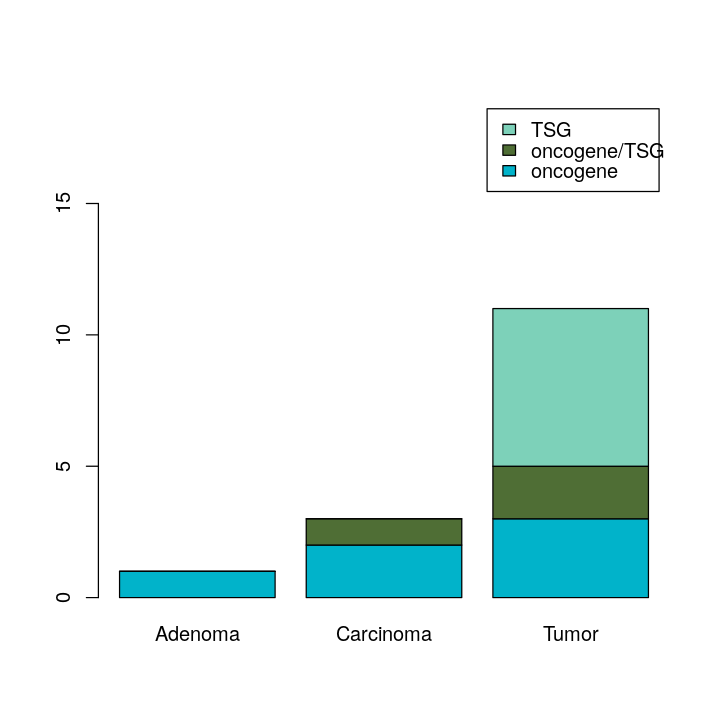

In [20]:
## Plot & save
barplot(tbl, legend=TRUE, ylim=c(0,max(apply(tbl,2,sum))+8), col=cols[c(4,5,7)]) # Add vertical space for legend
pdf(pep.roles)
barplot(tbl, legend=TRUE, ylim=c(0,max(apply(tbl,2,sum))+8), col=cols[c(4,5,7)]) # Add vertical space for legend
dev.off()

Unless the default paths have been changed above the
image files generated by this notebook may be downloaded using the
Jupyter directory browser interface at
[`./user_data/output`](./user_data/output).